In [10]:
import pandas as pd
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.probability import FreqDist
import matplotlib.pyplot as plt
from collections import Counter
from wordcloud import WordCloud
import string

In [3]:
# Descargar stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [5]:
stop_words = set(stopwords.words('english'))

In [6]:
df = pd.read_csv('scopus.csv')
df.head()

Title  \
0  NeuroIGN: Explainable Multimodal Image-Guided ...   
1  HPB3C-3PG algorithm: A new hybrid global optim...   
2  Health care providers acceptance of default pr...   
3  A von-Neumann-like photonic processor and its ...   
4  High-Performance Flow Classification of Big Da...   

                      Source title  \
0       Journal of Medical Systems   
1           Ecological Informatics   
2     BMC Health Services Research   
3  Light: Science and Applications   
4  Tsinghua Science and Technology   

                                                Link  \
0  https://www.scopus.com/inward/record.uri?eid=2...   
1  https://www.scopus.com/inward/record.uri?eid=2...   
2  https://www.scopus.com/inward/record.uri?eid=2...   
3  https://www.scopus.com/inward/record.uri?eid=2...   
4  https://www.scopus.com/inward/record.uri?eid=2...   

                                            Abstract  
0  Precise neurosurgical guidance is critical for...  
1  This paper proposes a hybrid bio-inspired sear...  
2  Background: Tuberculosis (TB) preventive treat...  
3  Photonic quantum computation plays an importan...  
4  The network switches in the data plane of Soft...

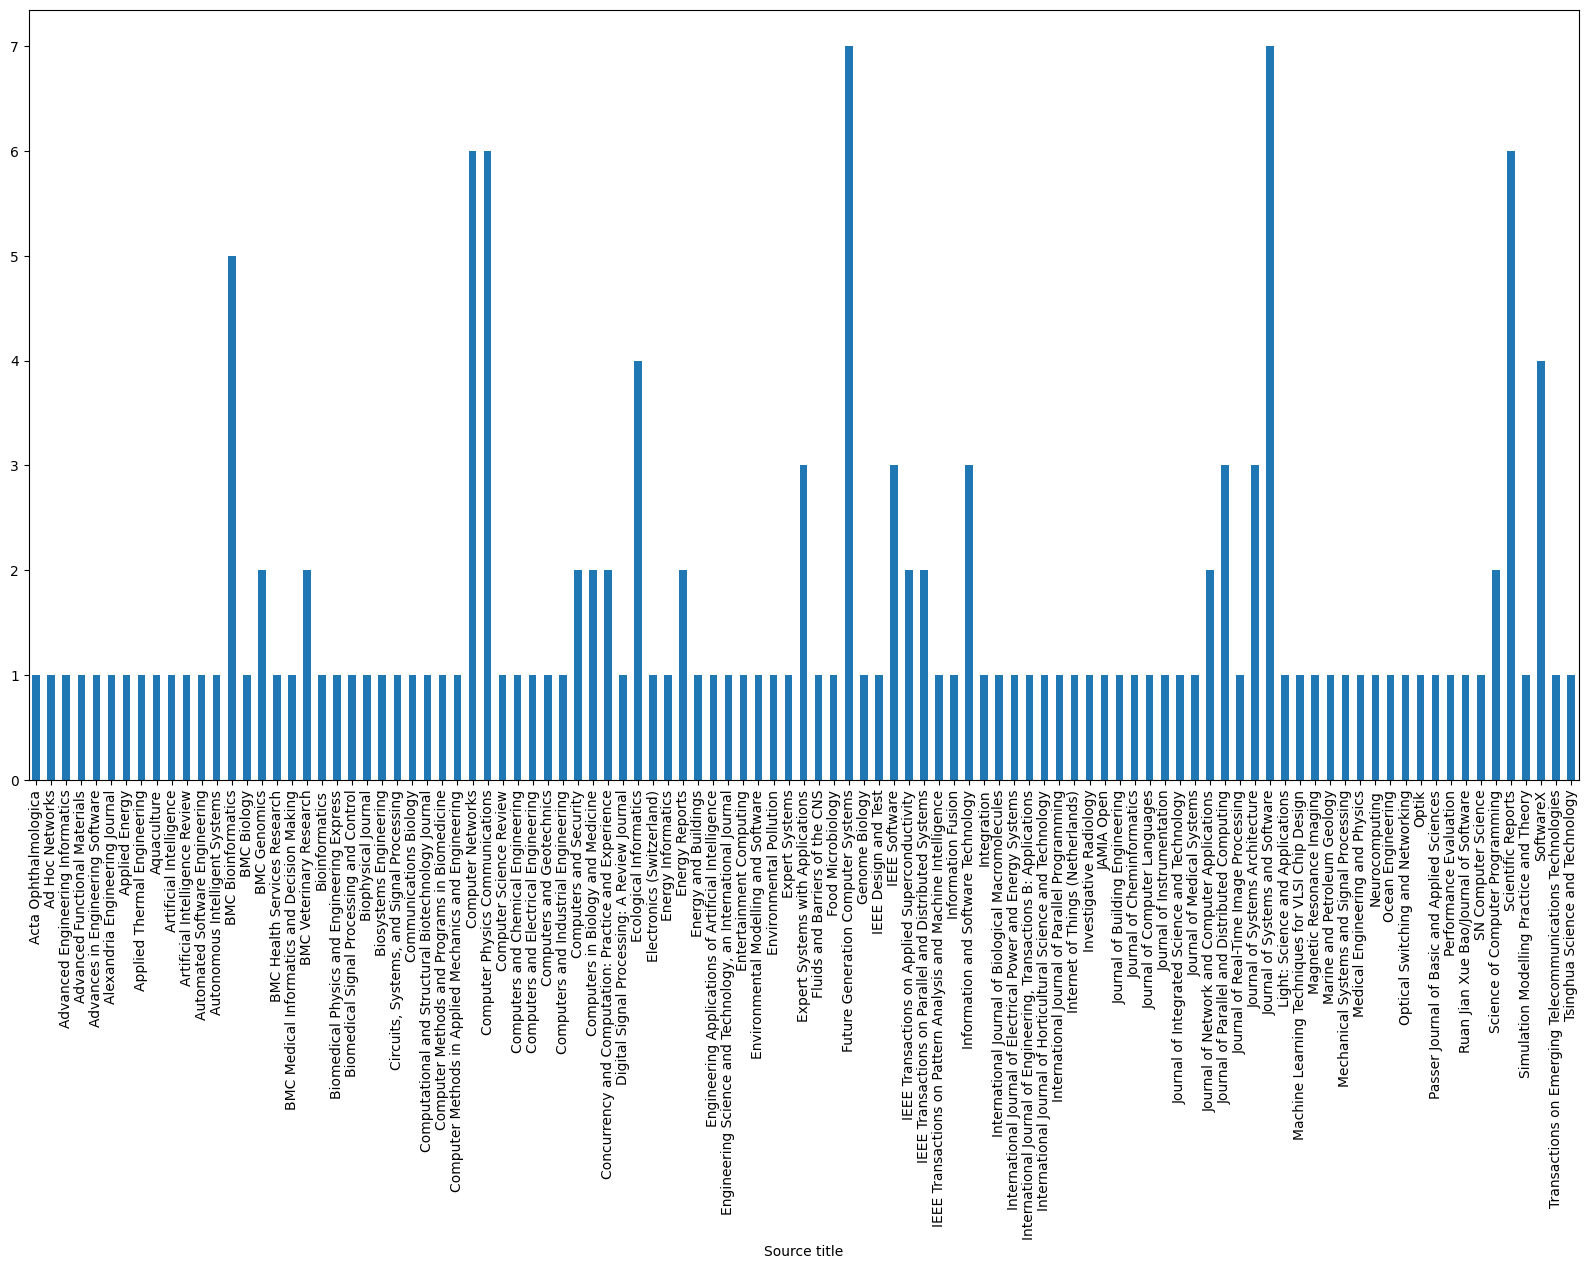

In [11]:
grouped = df.groupby('Source title')['Title'].count()
plt.figure(figsize=(20, 10))
grouped.plot(kind='bar')
plt.show()

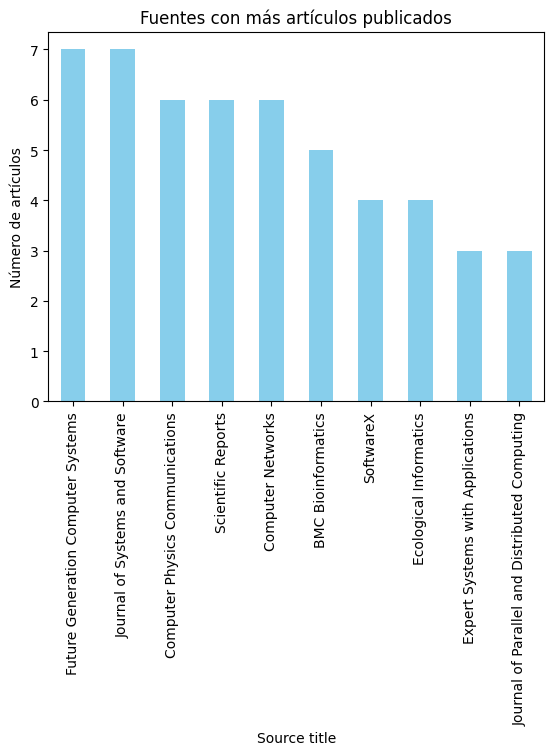

In [12]:
grouped = df.groupby('Source title')['Title'].count().sort_values(ascending=False)
top_sources = grouped.head(10)
top_sources.plot(kind='bar', color='skyblue')
plt.title('Fuentes con más artículos publicados')
plt.xlabel('Source title')
plt.ylabel('Número de artículos')
plt.show()

In [13]:
# Función para limpiar y preparar texto
def clean_text(text):
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    return ' '.join([word for word in text.split() if word not in stop_words])

# Analizar Titulos

In [14]:
# Aplicar la limpieza de texto a los títulos
df['clean_title'] = df['Title'].apply(clean_text)

# Contar palabras en todos los títulos
word_counts = Counter()
df['clean_title'].str.split().apply(word_counts.update)

# Crear un DataFrame a partir del contador de palabras
word_df = pd.DataFrame(word_counts.items(), columns=['Word', 'Frequency'])

# Ordenar las palabras por frecuencia de aparición, de mayor a menor
word_df = word_df.sort_values(by='Frequency', ascending=False).reset_index(drop=True)

# Añadir columna de rank
word_df['Rank'] = word_df['Frequency'].rank(method='dense', ascending=False)

# Mostrar el DataFrame de palabras ordenadas por rango
word_df.head(20)

Word  Frequency  Rank
0           using         20   1.0
1        learning         20   1.0
2    architecture         19   2.0
3           based         17   3.0
4          system         15   4.0
5        software         15   4.0
6   architectures         13   5.0
7        approach         11   6.0
8            deep         11   6.0
9     application         10   7.0
10      framework         10   7.0
11       analysis          9   8.0
12    performance          9   8.0
13         neural          8   9.0
14        network          8   9.0
15        systems          7  10.0
16         hybrid          7  10.0
17        machine          7  10.0
18         review          7  10.0
19          power          7  10.0

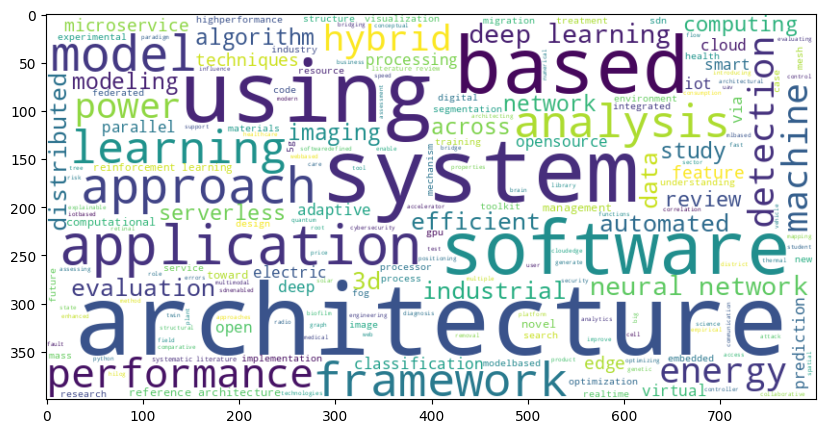

In [17]:
# Aplicar la limpieza de texto a los títulos
df['clean_title'] = df['Title'].apply(clean_text)

# Concatenar todos los títulos limpios en un solo texto
text = ' '.join(df['clean_title'])

wordcloud = WordCloud(width = 800, height = 400, background_color ='white').generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('on')
plt.show()

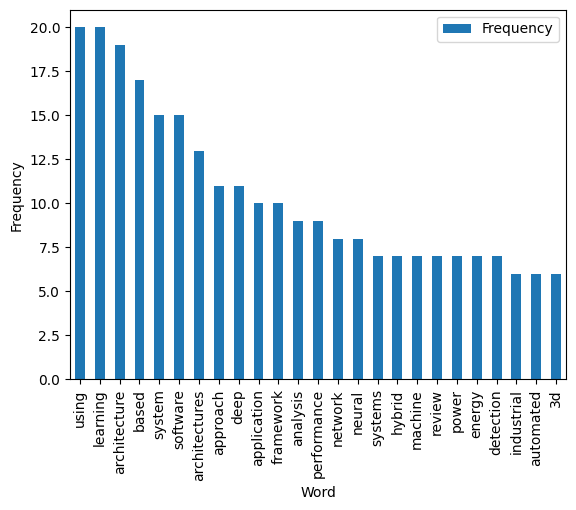

In [18]:
import matplotlib.pyplot as plt
word_df.sort_values(by='Frequency', ascending=False).head(25).plot(x='Word', y='Frequency', kind='bar')
plt.xlabel('Word')
_ = plt.ylabel('Frequency')

<ipython-input-19-5492a4065ecb>:27: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()  # Ajusta automáticamente los parámetros de la subtrama


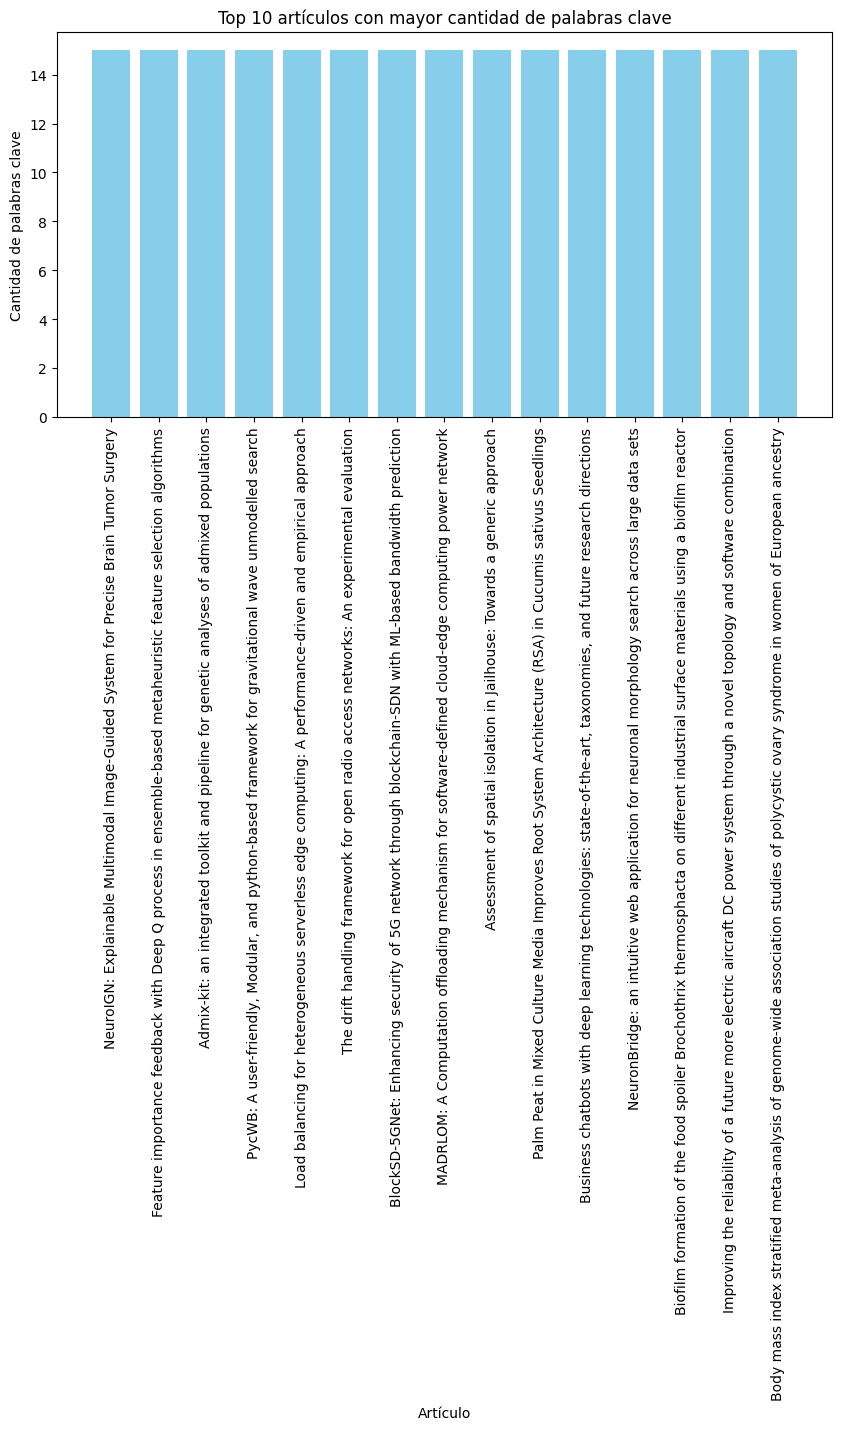

In [19]:
# Contar palabras en todos los títulos
word_counts = Counter()
df['Title'].apply(lambda title: word_counts.update(clean_text(title)))

# Determinar un número de palabras clave a considerar (e.g., top 10)
num_keywords = 15
keywords = [word for word, count in word_counts.most_common(num_keywords)]

# Función para contar cuántas palabras clave contiene cada título
def count_keywords(title):
    words = clean_text(title)
    return sum(word in words for word in keywords)

# Contar las palabras clave por título
df['keyword_count'] = df['Title'].apply(count_keywords)

# Ordenar el DataFrame por 'keyword_count' de forma descendente
df_sorted = df.sort_values(by='keyword_count', ascending=False)

# Graficar los top 10 artículos con más palabras clave
plt.figure(figsize=(10, 5))
plt.bar(df_sorted['Title'].head(15), df_sorted['keyword_count'].head(15), color='skyblue')
plt.xticks(rotation=90)
plt.xlabel('Artículo')
plt.ylabel('Cantidad de palabras clave')
plt.title('Top 10 artículos con mayor cantidad de palabras clave')
plt.tight_layout()  # Ajusta automáticamente los parámetros de la subtrama
plt.show()


# ANALIZAR ABSTRACT

In [20]:


# Seleccionar los abstracts de los artículos con más palabras clave
top_abstracts = df.sort_values(by='keyword_count', ascending=False).head(10)['Abstract']

# Función para resumir un abstract
def summarize_abstract(abstract):
    sentences = sent_tokenize(abstract)
    word_freq = FreqDist(clean_text(abstract))
    scores = {sentence: sum(word_freq[word] for word in word_tokenize(sentence.lower()) if word in word_freq) for sentence in sentences}
    summary_sentences = sorted(scores, key=scores.get, reverse=True)[:3]  # Tomar las 3 oraciones con mayor puntuación
    return ' '.join(summary_sentences)

# Aplicar la función de resumen a cada abstract seleccionado
top_abstracts_summary = top_abstracts.apply(summarize_abstract)

# Mostrar resúmenes
for i, summary in enumerate(top_abstracts_summary, 1):
    print(f"Resumen {i}:\n{summary}\n")


Resumen 1:
The proposed system was successfully assembled and set up within 11 min in a pre-clinical OR setting with a tracking accuracy of 0.5 (± 0.1) mm. Precise neurosurgical guidance is critical for successful brain surgeries and plays a vital role in all phases of image-guided neurosurgery (IGN). Neuronavigation software enables real-time tracking of surgical tools, ensuring their presentation with high precision in relation to a virtual patient model.

Resumen 2:
Specifically, the proposed model achieved a 9.5% higher precision, an 8.5% higher accuracy, an 8.3% higher recall, a 4.9% higher AUC, and a 5.9% higher specificity across multiple software bug prediction datasets and samples. This paper presents a novel approach that integrates the strengths of PSO, FA, and WOA algorithms into an ensemble model and further enhances its performance by incorporating a Deep Q-Learning framework for relevance feedbacks. This research provides an innovative framework for feature selection tha

In [28]:
# Contar la aparición de palabras clave en cada título
df['keyword_count'] = df['Title'].apply(lambda x: sum(word in clean_text(x) for word in word_df))

# Seleccionar los abstracts de los artículos con más palabras clave
top_articles = df.sort_values(by='keyword_count', ascending=False).head(10)

# Función para resumir un abstract
def summarize_abstract(abstract):
    sentences = sent_tokenize(abstract)
    word_freq = FreqDist(clean_text(abstract))
    scores = {sentence: sum(word_freq[word] for word in word_tokenize(sentence.lower()) if word in word_freq) for sentence in sentences}
    summary_sentences = sorted(scores, key=scores.get, reverse=True)[:2]
    return ' '.join(summary_sentences)

# Aplicar la función de resumen a cada abstract seleccionado y almacenar junto con el título
top_articles['Summary'] = top_articles['Abstract'].apply(summarize_abstract)

# Mostrar títulos y resúmenes
for index, row in top_articles.iterrows():
    print(f"Title: {row['Title']}\nSummary: {row['Summary']}\n")


Title: NeuroIGN: Explainable Multimodal Image-Guided System for Precise Brain Tumor Surgery
Summary: The proposed system was successfully assembled and set up within 11 min in a pre-clinical OR setting with a tracking accuracy of 0.5 (± 0.1) mm. Precise neurosurgical guidance is critical for successful brain surgeries and plays a vital role in all phases of image-guided neurosurgery (IGN).

Title: HPB3C-3PG algorithm: A new hybrid global optimization algorithm and its application to plant classification
Summary: This paper proposes a hybrid bio-inspired search and optimization algorithm that combines the strengths of the PB3C (Parallel Big Bang Big Crunch) and 3PGA (3 Parent Genetic Algorithm) algorithms. The hybrid algorithm employs a single population-based evolutionary search coupled with multi-population parallel processing techniques to address optimization problems.

Title: BlockSD-5GNet: Enhancing security of 5G network through blockchain-SDN with ML-based bandwidth prediction
S